In [1]:
import os
gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id)

In [2]:
import torch
curr_device = torch.cuda.current_device()
torch.cuda.get_device_name(curr_device)

'GeForce GTX 1080 Ti'

In [3]:
import numpy as np

from networks.faceid.sphereface import sphere20a
from networks.denoise.pydl import ResDNet
from networks.denoise.pydl import UDNet
from networks.denoise.pydl import UDNetPA

In [5]:
faceid = sphere20a(feature=True)

sphereface_wo_noise = "/home/safin/ckpt/sphereface_clean/sphere20a_19.pth"
faceid_ckpt = torch.load(sphereface_wo_noise)
faceid.load_state_dict(faceid_ckpt)
faceid = faceid.cuda()

In [6]:
from datasets.lfw import LFWDataset
from torchvision import transforms
transform = transforms.Compose([
                         transforms.ToTensor()
                     ])
test_dataset =  LFWDataset("/home/safin/datasets/lfw/lfw-sphereface/", "/home/safin/datasets/lfw/pairsDevTrain.txt", transform, "png")

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.mixture import GaussianMixture

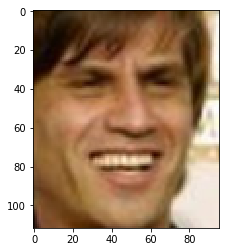

In [48]:
person_id = 2
image = test_dataset[person_id][0]
plt.imshow(image.permute(1,2,0))

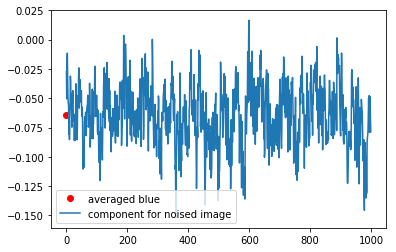

In [307]:
plt.plot(out[0], "ro", label="averaged blue")
plt.plot(component_arr, label="component for noised image")
plt.legend()

In [302]:
std = 55
MAX_PIXEL=255
person_id = 200
image = test_dataset[person_id][0]
emb_clean0 = faceid(((255*image-127.5)/128).unsqueeze(0).cuda()).cpu().data.numpy().reshape(-1)

out = 0
samples = 1000
component_arr = []
for i in range(samples):
    image = (image + torch.randn(*face_size)*std/MAX_PIXEL).clamp(0,1)
    emb_noisy0 = faceid(((255*image-127.5)/128).unsqueeze(0).cuda()).cpu().data.numpy().reshape(-1)
    out += emb_noisy0
    component_arr.append(emb_noisy0[0])
out /= samples

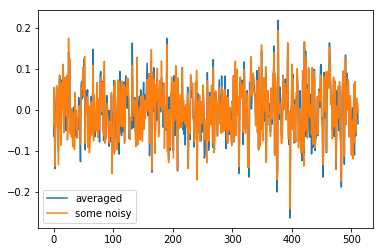

In [300]:
plt.plot(out, label="averaged")
plt.plot(emb_noisy0, label="some noisy")
plt.legend()

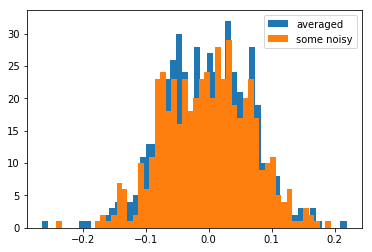

In [301]:
# plt.hist(emb_clean0, bins=50)
plt.hist(out, bins=50, label="averaged")
plt.hist(emb_noisy0, bins=50, label="some noisy")
plt.legend()

In [123]:
std = 55
MAX_PIXEL=255
person_id = 200
image = test_dataset[person_id][0]
emb_clean0 = faceid(((255*image-127.5)/128).unsqueeze(0).cuda()).cpu().data.numpy().reshape(-1)
image = (image + torch.randn(*face_size)*std/MAX_PIXEL).clamp(0,1)
emb_noisy0 = faceid(((255*image-127.5)/128).unsqueeze(0).cuda()).cpu().data.numpy().reshape(-1)

In [247]:
def plot_for_person(person_id):
    image = test_dataset[person_id][0]
    emb_clean0 = faceid(((255*image-127.5)/128).unsqueeze(0).cuda()).cpu().data.numpy().reshape(-1)
    image = (image + torch.rand(*face_size)*std/MAX_PIXEL).clamp(0,1)
    emb_noisy0 = faceid(((255*image-127.5)/128).unsqueeze(0).cuda()).cpu().data.numpy().reshape(-1)

    gmm = GaussianMixture(n_components=1)
    diff = emb_clean0 - emb_noisy0
    gmm.fit(diff.reshape(-1,1))

    sigma = np.sqrt(gmm.covariances_).reshape(1)
    mu = gmm.means_.reshape(1)
    x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
    y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    plt.hist(diff, bins=50, normed=True)
    print("wmad for emb_noisy0:", pydlutil.wmad_estimator(emb_noisy0.reshape(32,-1)))
    plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
    plt.legend()
    plt.title("Difference between components of embedding for person %i" % person_id)
    return diff

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


wmad for emb_noisy0: [[1.1584477]]


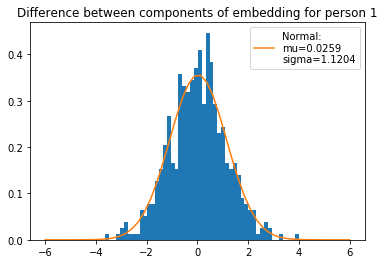

In [151]:
diff = plot_for_person(1)

wmad for emb_noisy0: [[1.1064934]]


/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0.7981745, -0.036374044, 0.21568627450980393)

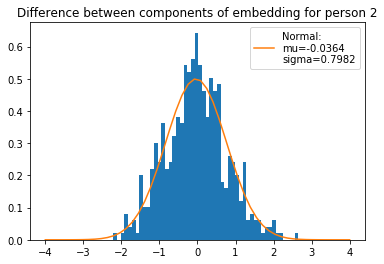

In [249]:
diff = plot_for_person(2)
diff.std(), diff.mean(), 55/255

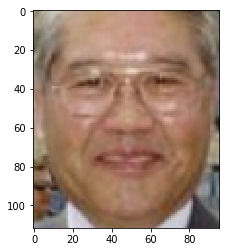

In [269]:
image = test_dataset[person_id][0].permute(1,2,0).numpy()
std_ = 20/255
samples = 1000
noisy_image = 0
for i in range(samples):
    est = image + std_ * np.random.randn(*image.shape)
    noisy_image += est.clip(0,1)
noisy_image /= samples
plt.imshow(noisy_image.clip(0,1))

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


wmad for emb_noisy0: [[1.595592]]


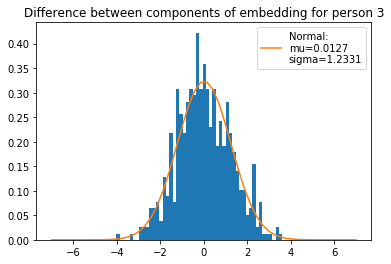

In [154]:
diff = plot_for_person(3)

In [120]:
torch.randn(image.shape).min()

tensor(-3.8511)

In [118]:
torch.rand(image.shape).min()

tensor(8.7023e-06)

In [239]:
20/255

0.0784313725490196

In [238]:
pydlutil.wmad_estimator((image+torch.randn(image.shape)*20/255).clamp(0,1))

tensor([[0.2105]])

In [229]:
pydlutil.wmad_estimator((image+torch.randn(image.shape)*2).reshape(1,-1))

tensor([[5.8459e-08]])

In [234]:
(image+torch.randn(image.shape)*2).reshape(1,-1).std()

tensor(2.0190)

In [224]:
emb_clean0.shape

(512,)

In [106]:
pydlutil.wmad_estimator(6+torch.rand(emb_clean0.shape))

tensor([[2.2177e-07]])

In [149]:
torch.randn(emb_clean0.shape).reshape(32,-1).shape

torch.Size([32, 16])

In [163]:
diff

array([-6.39941216e-01,  1.15874648e+00,  4.31473225e-01,  1.96226525e+00,
       -1.28182322e-01,  3.24065161e+00,  1.14829266e+00, -1.44216537e+00,
        2.69017696e-01,  9.48183417e-01,  1.25229394e+00,  1.01727712e+00,
       -2.35288739e-01,  9.43126738e-01, -1.07669890e+00, -8.60504985e-01,
       -5.55500984e-01, -2.11709827e-01, -1.74115252e+00,  1.21915650e+00,
       -8.97333086e-01,  2.23517489e+00,  1.86225390e+00,  4.89801049e-01,
        2.20175982e+00, -2.43340468e+00,  3.30411047e-01, -1.61442590e+00,
       -4.98696238e-01, -7.48798609e-01, -3.07674789e+00,  1.46694660e+00,
       -1.85313392e+00,  4.57034528e-01,  4.41127014e+00,  2.56231689e+00,
        2.79848605e-01,  2.81545186e+00, -5.31570244e+00,  1.34762132e+00,
        6.59826025e-02,  2.09661961e+00, -3.69483161e+00, -1.79863918e+00,
        7.42858589e-01,  2.20007017e-01, -9.51913297e-01,  3.26534534e+00,
       -2.73210120e+00, -7.91942894e-01,  1.29513741e+00, -2.64495349e+00,
        1.51830232e+00,  

In [223]:
pydlutil.wmad_estimator(image.reshape(-1,1)+true_sigma*torch.randn(image.shape).reshape(-1,1))

tensor([[5.6741e-09]])

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Error of WMAD estimator for GN (sigma=0.22)')

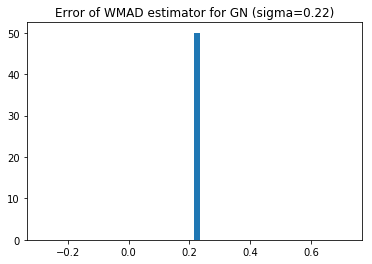

In [220]:
diff = []
true_sigma = 55/255
for i in range(1000):
    sigma_est = pydlutil.wmad_estimator(image.reshape(-1,1)+true_sigma*torch.randn(image.shape).reshape(-1,1))
    diff.append(true_sigma-sigma_est)

diff = np.asarray(diff)
gmm = GaussianMixture(n_components=1)
gmm.fit(diff.reshape(-1,1))

sigma = np.sqrt(gmm.covariances_).reshape(1)
mu = gmm.means_.reshape(1)
x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
plt.hist(diff, bins=50, normed=True)
# plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
# plt.legend()
plt.title("Error of WMAD estimator for GN (sigma=%.2f)" % true_sigma)

In [221]:
diff

array([0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568628,
       0.21568628, 0.21568628, 0.21568628, 0.21568628, 0.21568

Text(0.5, 1.0, 'Error of WMAD estimator for GN (sigma=0.22)')

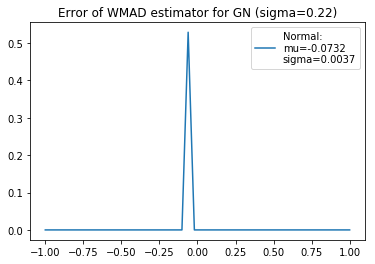

In [216]:
plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
plt.legend()
plt.title("Error of WMAD estimator for GN (sigma=%.2f)" % true_sigma)

In [202]:
np.random.randn(1000).dtype

dtype('float64')

(array([597.22610432,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
        597.22610432,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
        597.22610432,   0.        , 597.22610432, 597.22610432,
          0.        ,   0.        ,   0.        , 597.22610432,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 597.22610432,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 597.22610432,   0.        , 597.22610432,
          0.        , 597.22610432]),
 array([-0.07721286, -0.07704541, -0.07687797, -0.07671053, -0.07654309,
        -0.07637565, -0.07620821, -0.07604077, -0.07587333, -0.07570589,
        -0.07553845, -0.07537101, -0.07520357, -

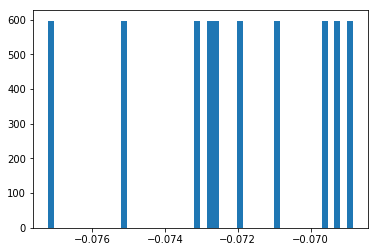

In [214]:
plt.hist(diff[:10], bins=50, density=True)

In [205]:
diff = diff.astype(np.float64)

(array([ 70.38972928,   0.        ,  70.38972928,   0.        ,
         35.19486464,  35.19486464,   0.        ,   0.        ,
         70.38972928,   0.        ,  70.38972928, 140.77945856,
         70.38972928, 105.58459392,  70.38972928,  70.38972928,
         70.38972928,  35.19486464, 175.9743232 , 140.77945856,
         70.38972928, 140.77945856, 175.9743232 ,  70.38972928,
         70.38972928, 105.58459392,  70.38972928, 140.77945856,
        140.77945856,   0.        , 105.58459392, 140.77945856,
        140.77945856,   0.        ,  70.38972928, 105.58459392,
        105.58459392, 105.58459392, 211.16918785,  35.19486464,
         70.38972928,  70.38972928,   0.        ,  35.19486464,
          0.        ,   0.        ,   0.        ,  70.38972928,
          0.        ,  35.19486464]),
 array([-0.0806873 , -0.08040317, -0.08011903, -0.0798349 , -0.07955077,
        -0.07926664, -0.07898251, -0.07869837, -0.07841424, -0.07813011,
        -0.07784598, -0.07756184, -0.07727771, -

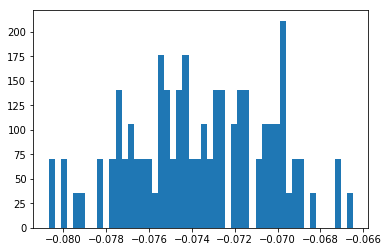

In [204]:
plt.hist(diff[:100].astype(np.float64), bins=50, density=True)

Text(0.5, 1.0, 'Error of WMAD estimator for GN (sigma=0.22)')

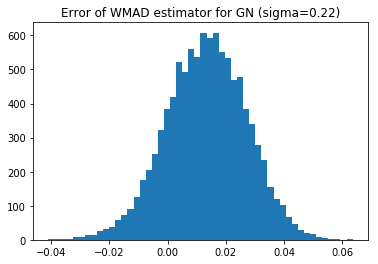

In [219]:
diff = []
true_sigma = 55/255
for i in range(10000):
    sigma_est = pydlutil.wmad_estimator(10+true_sigma*torch.randn((32,32)))
    diff.append(true_sigma-sigma_est)

diff = np.asarray(diff)
gmm = GaussianMixture(n_components=1)
gmm.fit(diff.reshape(-1,1))

sigma = np.sqrt(gmm.covariances_).reshape(1)
mu = gmm.means_.reshape(1)
x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
plt.hist(diff, bins=50)
plt.title("Error of WMAD estimator for GN (sigma=%.2f)" % true_sigma)

In [ ]:
plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
plt.legend()
plt.title("Error of WMAD estimator for GN (sigma=%.2f)" % true_sigma)

In [148]:
pydlutil.wmad_estimator(10+torch.randn(emb_clean0.shape).reshape(32,-1))

tensor([[0.8259]])

In [140]:
pydlutil.wmad_estimator(emb_noisy0.reshape(-1,1))

array([[1.3962665e-09]], dtype=float32)

In [99]:
emb_noisy0.shape

(512,)

In [79]:
import sys
sys.path.append("/home/safin/pydl")

In [81]:
from pydl import utils as pydlutil
pydlutil.wmad_estimator(diff)

array([[1.805775e-08]], dtype=float32)

In [55]:
std = 55
MAX_PIXEL=255
person_id = 20
image = test_dataset[person_id][0]
emb_clean0 = faceid((image-image.mean()).unsqueeze(0).cuda())
image = (image + torch.rand(*face_size)*std/MAX_PIXEL).clamp(0,1)
emb_noisy0 = faceid((image-image.mean()).unsqueeze(0).cuda())

(array([0.03594407, 0.02396268, 0.        , 0.02396271, 0.02396268,
        0.04792542, 0.0958507 , 0.09585084, 0.04792542, 0.05990669,
        0.11981355, 0.22764558, 0.15575762, 0.1797202 , 0.1557575 ,
        0.22764558, 0.17972033, 0.23962693, 0.21566431, 0.19170154,
        0.17972026, 0.29953369, 0.34745911, 0.27557102, 0.32349641,
        0.16773888, 0.20368293, 0.16773891, 0.26358962, 0.25160827,
        0.13179491, 0.1797202 , 0.09585077, 0.19170168, 0.16773885,
        0.04792539, 0.08386949, 0.0958507 , 0.08386949, 0.02396271,
        0.03594401, 0.04792542, 0.04792542, 0.01198134, 0.        ,
        0.        , 0.01198136, 0.02396268, 0.01198137, 0.01198134]),
 array([-3.7901316 , -3.6271179 , -3.464104  , -3.3010902 , -3.1380765 ,
        -2.9750626 , -2.812049  , -2.649035  , -2.4860213 , -2.3230076 ,
        -2.1599936 , -1.99698   , -1.8339661 , -1.6709524 , -1.5079386 ,
        -1.3449248 , -1.181911  , -1.0188973 , -0.8558835 , -0.6928697 ,
        -0.5298559 , -0.36

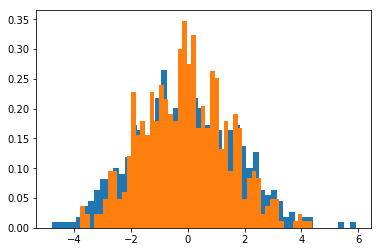

In [56]:
plt.hist(emb_clean0.cpu().data.numpy().reshape(-1), bins=50, normed=True)
plt.hist(emb_noisy0.cpu().data.numpy().reshape(-1), bins=50, normed=True)

In [53]:
person_id = 0
image = test_dataset[person_id][0]
emb_clean1 = faceid((image-image.mean()).unsqueeze(0).cuda())

person_id = 20
image = test_dataset[person_id][0]
emb_clean0 = faceid((image-image.mean()).unsqueeze(0).cuda())

(array([0.01207604, 0.01207601, 0.        , 0.        , 0.01207602,
        0.01207602, 0.03622807, 0.02415205, 0.04830417, 0.04830409,
        0.02415205, 0.12076024, 0.09660819, 0.04830417, 0.08453216,
        0.06038012, 0.10868421, 0.14491228, 0.13283636, 0.21736842,
        0.21736858, 0.22944445, 0.15698836, 0.33812866, 0.33812878,
        0.26567259, 0.26567259, 0.18114039, 0.3019007 , 0.25359654,
        0.3743568 , 0.27774864, 0.13283631, 0.27774854, 0.16906445,
        0.21736842, 0.12076024, 0.10868429, 0.16906433, 0.10868421,
        0.04830409, 0.06038021, 0.06038012, 0.02415205, 0.07245614,
        0.02415205, 0.06038012, 0.02415208, 0.02415205, 0.03622807]),
 array([-4.4366302 , -4.2748947 , -4.1131587 , -3.9514232 , -3.7896874 ,
        -3.6279516 , -3.4662158 , -3.30448   , -3.1427443 , -2.9810088 ,
        -2.819273  , -2.6575372 , -2.4958014 , -2.3340657 , -2.1723301 ,
        -2.0105944 , -1.8488586 , -1.6871228 , -1.525387  , -1.3636514 ,
        -1.2019156 , -1.04

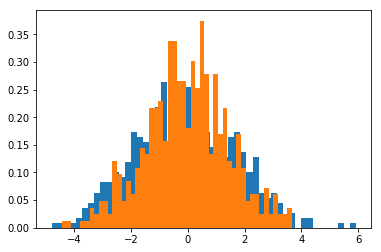

In [54]:
plt.hist(emb_clean0.cpu().data.numpy().reshape(-1), bins=50, normed=True)
plt.hist(emb_clean1.cpu().data.numpy().reshape(-1), bins=50, normed=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


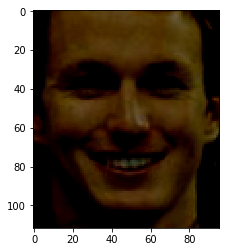

In [30]:
centered_img = (test_dataset[person_id][0] - test_dataset[person_id][0].mean()).cpu().data.permute(1,2,0).numpy()
plt.imshow(centered_img)

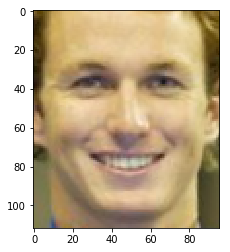

In [34]:
plt.imshow(centered_img - centered_img.min())

In [9]:
test_dataset[person_id][0].shape

torch.Size([3, 112, 96])

In [37]:
emb_clean = faceid((image*2 - 1).unsqueeze(0).cuda())
face_size = test_dataset[person_id][0].shape
_, emb_dim = emb_clean.shape

std = 55
MAX_PIXEL=255
img = (test_dataset[person_id][0] + torch.rand((1, *face_size))*std/MAX_PIXEL).clamp(0,1)
img = 2*img - 1 #(img*255 - 127.5)/128
emb_noised = faceid(img.cuda()) 
diff = emb_noised - emb_clean

In [24]:
diff = diff.reshape(-1).data.cpu().numpy()

torch.Size([1, 512])

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


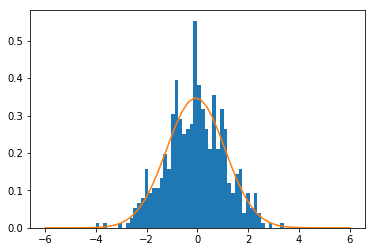

In [44]:
gmm = GaussianMixture(n_components=1)
gmm.fit(diff.reshape(-1,1))

sigma = np.sqrt(gmm.covariances_).reshape(1)
mu = gmm.means_.reshape(1)
x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
plt.hist(diff, bins=50, normed=True)
plt.plot(x, y)

In [48]:
emb_clean = faceid((image*2 - 1).unsqueeze(0).cuda())
face_size = test_dataset[person_id][0].shape
_, emb_dim = emb_clean.shape

n_iterations = 100
batch_size = 64
ans2 = np.empty(((n_iterations*batch_size), emb_dim))

std = 55
MAX_PIXEL=255

for i in range(n_iterations):
    img = (test_dataset[person_id][0] + torch.rand((batch_size, *face_size))*std/MAX_PIXEL).clamp(0,1)
    img = 2*img - 1 #(img*255 - 127.5)/128
    emb_noised = faceid(img.cuda()) 
    diff = emb_noised - emb_clean
    ans2[i*batch_size:(i+1)*batch_size] = diff.cpu().data.tolist()

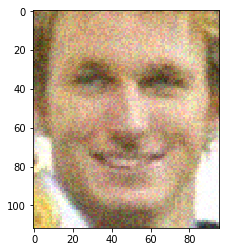

In [43]:
plt.imshow((img[0].permute(1,2,0)+1)/2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


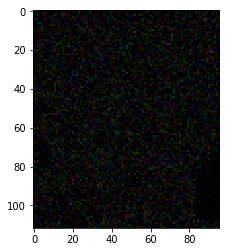

In [45]:
plt.imshow((img[1].permute(1,2,0)+1)/2 - (img[0].permute(1,2,0)+1)/2)

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


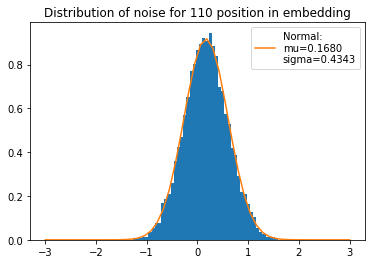

In [74]:
n_pos = 110
t = ans2[:, n_pos].reshape(-1,1)
gmm = GaussianMixture(n_components=1)
gmm.fit(t)

sigma = np.sqrt(gmm.covariances_).reshape(1)
mu = gmm.means_.reshape(1)
x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

tmp = plt.hist(t, bins=50, normed=True)
plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
plt.title("Distribution of noise for %s position in embedding" % n_pos)
plt.legend()

/home/safin/miniconda3/envs/py36ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


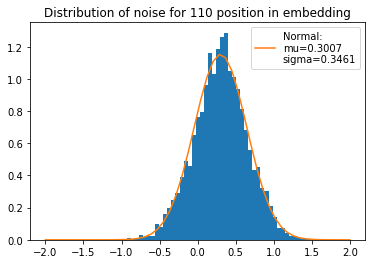

In [72]:
n_pos = 110
t = ans[:, n_pos].reshape(-1,1)
gmm = GaussianMixture(n_components=1)
gmm.fit(t)

sigma = np.sqrt(gmm.covariances_).reshape(1)
mu = gmm.means_.reshape(1)
x = np.linspace(-int(np.ceil(5*sigma)),int(np.ceil(5*sigma)))
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

tmp = plt.hist(t, bins=50, normed=True)
plt.plot(x, y, label="Normal: \nmu=%.4f\nsigma=%.4f" % (mu, sigma))
plt.title("Distribution of noise for %s position in embedding" % n_pos)
plt.legend()

(array([   7.,   33.,  226.,  688., 1464., 1821., 1326.,  611.,  194.,
          30.]),
 array([-1.52864051, -1.21643711, -0.90423372, -0.59203032, -0.27982693,
         0.03237647,  0.34457986,  0.65678326,  0.96898665,  1.28119005,
         1.59339345]),
 <a list of 10 Patch objects>)

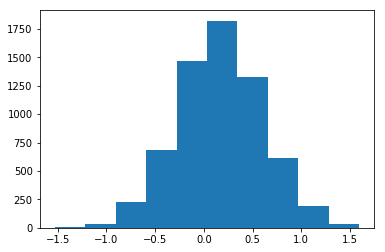

In [71]:
plt.hist(t)

In [75]:
import scipy
scipy.stats.normaltest(t)

NormaltestResult(statistic=array([0.00340576]), pvalue=array([0.99829857]))

In [76]:
import scipy
scipy.stats.normaltest(0.3*np.random.randn(6400)+0.3)

NormaltestResult(statistic=3.81188821013453, pvalue=0.14868220471561805)

(array([0.02141546, 0.        , 0.03212318, 0.02141546, 0.02855394,
        0.03569243, 0.11064652, 0.10350803, 0.13563122, 0.19987758,
        0.3105241 , 0.4283091 , 0.43187835, 0.57821729, 0.60320199,
        0.71741775, 0.86732594, 1.06720352, 1.12788064, 1.34917368,
        1.33132747, 1.37058913, 1.32775822, 1.34203519, 1.18855776,
        1.09575746, 1.05649579, 1.08861897, 0.81735654, 0.82806427,
        0.6710176 , 0.65317138, 0.41046289, 0.37477047, 0.28197016,
        0.23557001, 0.18203137, 0.11064652, 0.117785  , 0.03569243,
        0.06067712, 0.0249847 , 0.02855394, 0.01427697, 0.00356924,
        0.00713849, 0.00713849, 0.00356924, 0.        , 0.00356924]),
 array([-0.68865404, -0.64487724, -0.60110045, -0.55732365, -0.51354686,
        -0.46977006, -0.42599326, -0.38221647, -0.33843967, -0.29466288,
        -0.25088608, -0.20710929, -0.16333249, -0.1195557 , -0.0757789 ,
        -0.03200211,  0.01177469,  0.05555148,  0.09932828,  0.14310507,
         0.18688187,  0.23

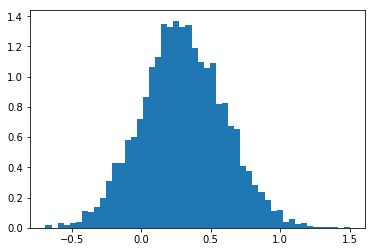

In [60]:
plt.hist(0.3*np.random.randn(6400)+0.3, bins=50, normed=True)